In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import glob
from xml.etree import ElementTree

In [3]:
annotations_directory = './data/annotations'
images_directory = './data/images'

In [4]:
irectory = './data/annotations'
images_directory = './data/images'

In [5]:
information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(annotations_directory + '/*.xml'):
    tree = ElementTree.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag: 
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))    

        if 'object' in element.tag:
            for attribute in list(element):
                
                if 'name' in attribute.tag:
                    name = attribute.text                 
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height] 
                    information['file'] += [annotation.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]

In [6]:
annotations_info_df = pd.DataFrame(information)
annotations_info_df.head(10)

,xmin,ymin,xmax,ymax,label,file,width,height
0,62,194,160,320,without_mask,maksssksksss299,301,400
1,43,169,149,308,without_mask,maksssksksss528,301,400
2,48,107,218,304,mask_weared_incorrect,maksssksksss272,275,400
3,28,78,43,99,with_mask,maksssksksss514,400,267
4,160,66,176,83,with_mask,maksssksksss514,400,267
5,174,33,186,52,with_mask,maksssksksss514,400,267
6,202,40,216,59,with_mask,maksssksksss514,400,267
7,237,41,248,58,without_mask,maksssksksss514,400,267
8,249,44,266,66,mask_weared_incorrect,maksssksksss514,400,267
9,298,38,311,54,with_mask,maksssksksss514,400,267


In [7]:
# Add Annotation and Image File Names
annotations_info_df['annotation_file'] = annotations_info_df['file'] + '.xml'
annotations_info_df['image_file'] = annotations_info_df['file'] + '.png'

# Tidy Grammatical Issue
annotations_info_df.loc[annotations_info_df['label'] == 'mask_weared_incorrect', 'label'] = 'mask_incorrectly_worn'

In [9]:
def render_image(image_path):
    image = cv2.imread(image_path)
    img=image_path.split('/')[-1]
    #print(image.shape)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bound_box=[]
    for i in annotations_info_df[annotations_info_df['image_file']==img].index:
        (x,y,width,height)=(annotations_info_df.loc[i].xmin,annotations_info_df.loc[i].ymin,
                        annotations_info_df.loc[i].xmax,annotations_info_df.loc[i].ymax)
        bound_box.append((x,y,width,height))  
        if annotations_info_df.loc[i].label=='with_mask':
            cv2.rectangle(image, (x,y), (x+width, y+height), (0, 200, 0), 2)
            cv2.putText(image, org = (x-8 , y-8), text = "Mask", 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (0, 200, 0))
        elif annotations_info_df.loc[i].label=='mask_incorrectly_worn':
            cv2.rectangle(image, (x,y), (x+width, y+height), (255, 255, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'Incorrect', 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (255, 255, 0))
        else:
            cv2.rectangle(image, (x,y), (x+width, y+height), (200, 0, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'No mask', 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (200, 0, 0))
        
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()
    
    return bound_box,image

In [10]:
images_with_2=[]
for _ in annotations_info_df['image_file'].value_counts().index:
    if annotations_info_df[annotations_info_df['image_file']==_].shape[0]==2:
        images_with_2.append(_)

In [12]:
annotations_info_df.loc[0]

xmin                                62
ymin                               194
xmax                               160
ymax                               320
label                     without_mask
file                   maksssksksss299
width                              301
height                             400
annotation_file    maksssksksss299.xml
image_file         maksssksksss299.png
Name: 0, dtype: object

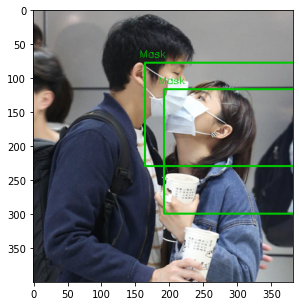

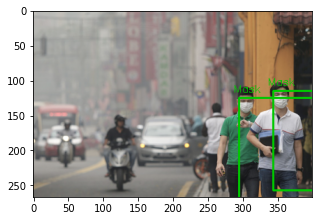

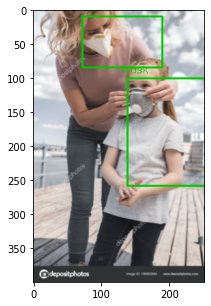

In [14]:
for i in images_with_2[:3]:
    render_image(os.path.join(images_directory,i))

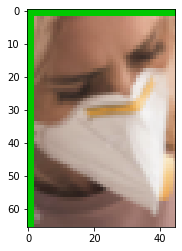

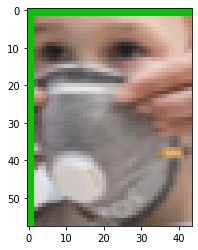

In [16]:
for i in bound_box:
    cropped = image[i[1]:i[3],i[0]:i[2]]
    plt.imshow(cropped)
    plt.show()

In [18]:
directory = 'cropped_images'
parent_directory = 'data'
path = os.path.join(parent_directory, directory)
os.mkdir(path)

In [19]:
annotations_info_df['cropped_image_file'] = annotations_info_df['file']
annotations_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,62,194,160,320,without_mask,maksssksksss299,301,400,maksssksksss299.xml,maksssksksss299.png,maksssksksss299
1,43,169,149,308,without_mask,maksssksksss528,301,400,maksssksksss528.xml,maksssksksss528.png,maksssksksss528
2,48,107,218,304,mask_incorrectly_worn,maksssksksss272,275,400,maksssksksss272.xml,maksssksksss272.png,maksssksksss272
3,28,78,43,99,with_mask,maksssksksss514,400,267,maksssksksss514.xml,maksssksksss514.png,maksssksksss514
4,160,66,176,83,with_mask,maksssksksss514,400,267,maksssksksss514.xml,maksssksksss514.png,maksssksksss514
...,...,...,...,...,...,...,...,...,...,...,...
4067,271,73,278,82,without_mask,maksssksksss294,400,241,maksssksksss294.xml,maksssksksss294.png,maksssksksss294
4068,236,91,243,99,without_mask,maksssksksss294,400,241,maksssksksss294.xml,maksssksksss294.png,maksssksksss294
4069,236,76,243,83,without_mask,maksssksksss294,400,241,maksssksksss294.xml,maksssksksss294.png,maksssksksss294
4070,264,76,268,82,with_mask,maksssksksss294,400,241,maksssksksss294.xml,maksssksksss294.png,maksssksksss294


In [20]:
for i in range(len(annotations_info_df)):
    # Get The File Path and Read The Image
    image_filepath = './data/images/' + annotations_info_df['image_file'].iloc[i]
    image = cv2.imread(image_filepath)
    
    # Set The Cropped Image File Name
    annotations_info_df['cropped_image_file'].iloc[i] = annotations_info_df['cropped_image_file'].iloc[i] + '-' + str(i) + '.png'
    cropped_image_filename = annotations_info_df['cropped_image_file'].iloc[i]
    
    # Get The xmin, ymin, xmax, ymax Value (Bounding Box) to Crop Image
    xmin = annotations_info_df['xmin'].iloc[i]
    ymin = annotations_info_df['ymin'].iloc[i]
    xmax = annotations_info_df['xmax'].iloc[i]
    ymax = annotations_info_df['ymax'].iloc[i]

    # Crop The Image Based on The Values Above
    cropped_image = image[ymin:ymax, xmin:xmax]
    
    cropped_image_directory = os.path.join('./cropped_images', cropped_image_filename) 
    cv2.imwrite(cropped_image_directory, cropped_image)

/var/folders/_r/h6zxn_8952d00xhgshlztwt80000gn/T/ipykernel_10901/1227340749.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_info_df['cropped_image_file'].iloc[i] = annotations_info_df['cropped_image_file'].iloc[i] + '-' + str(i) + '.png'
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [22]:
classes=annotations_info_df['label'].unique()

In [24]:
labels=annotations_info_df['label']
annotations_info_df.drop(['label'],axis=1,inplace=True)

In [25]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(annotations_info_df,labels,test_size=0.25,stratify=labels,random_state=42)

In [28]:
image_width = []
image_height = []
for i in range(len(X_train)):
    cropped_image_path = './cropped_images/' + X_train['cropped_image_file'].iloc[i]
    cropped_image = cv2.imread(cropped_image_path)
    image_width.append(cropped_image.shape[0])
    image_height.append(cropped_image.shape[1])

In [29]:
print('IMAGE WIDTH')
print(f'Min: {min(image_width)}')
print(f'Max: {max(image_width)}')
print(f'Mean: {np.mean(image_width)}')
print(f'Median: {np.median(image_width)}')
print('IMAGE HEIGHT')
print(f'Min: {min(image_height)}')
print(f'Max: {max(image_height)}')
print(f'Mean: {np.mean(image_height)}')
print(f'Median: {np.median(image_height)}')

IMAGE WIDTH
Min: 2
Max: 340
Mean: 34.70988867059594
Median: 24.0
IMAGE HEIGHT
Min: 1
Max: 317
Mean: 30.814996725605763
Median: 22.0


In [30]:
image_target_size = (int(60), int(60))
image_target_size

(60, 60)

In [31]:
X_train['label']=Y_train
X_test['label']=Y_test

In [33]:
from keras_preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale = 1. / 255.)
train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = './cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 3054 validated image filenames belonging to 3 classes.


In [34]:
class_ind=train_generator.class_indices
train_generator.class_indices
#class_ind={'with_mask':0,
                   #'without_mask':1,
                   #'mask_incorrectly_worn':2}
#train_generator.class_indices['with_mask'] = 0
#train_generator.class_indices['without_mask'] = 1
#train_generator.class_indices['mask_incorrectly_worn'] = 2

{'mask_incorrectly_worn': 0, 'with_mask': 1, 'without_mask': 2}

In [35]:
test_image_generator = ImageDataGenerator(rescale = 1. / 255.)

test_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = './cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 1018 validated image filenames belonging to 3 classes.


In [37]:
def my_model():
    inputs = keras.Input(shape=(60,60, 3))
    x = layers.Conv2D(32, 3)(inputs)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
#     x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
#     x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
#    x=layers.Dropout(0.5)(x)
#    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(3,activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [38]:
model=my_model()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 58, 58, 32)       128       
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 58, 58, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 64)       256       
 hNormalization)                                             

In [41]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [44]:
model.compile(loss = focal_loss(alpha = 1.),
                optimizer = keras.optimizers.Adam(learning_rate=0.001),
                metrics = ['accuracy'])

history_1 = model.fit(train_generator, epochs = 10, steps_per_epoch = len(train_generator),
                     validation_data = test_generator, validation_steps = len(test_generator))

Epoch 1/10
96/96 [==============================] - 48s 492ms/step - loss: nan - accuracy: 0.0301 - val_loss: nan - val_accuracy: 0.0305
Epoch 2/10
 6/96 [>.............................] - ETA: 42s - loss: nan - accuracy: 0.0573

KeyboardInterrupt: 

In [45]:
model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(learning_rate=0.001),
                metrics = ['accuracy'])

history_1 = model.fit(train_generator, epochs = 10, steps_per_epoch = len(train_generator),
                     validation_data = test_generator, validation_steps = len(test_generator))

Epoch 1/10
96/96 [==============================] - 52s 537ms/step - loss: nan - accuracy: 0.0301 - val_loss: nan - val_accuracy: 0.0305
Epoch 2/10
96/96 [==============================] - 53s 547ms/step - loss: nan - accuracy: 0.0301 - val_loss: nan - val_accuracy: 0.0305
Epoch 3/10
96/96 [==============================] - 55s 571ms/step - loss: nan - accuracy: 0.0301 - val_loss: nan - val_accuracy: 0.0305
Epoch 4/10
96/96 [==============================] - 54s 567ms/step - loss: nan - accuracy: 0.0301 - val_loss: nan - val_accuracy: 0.0305
Epoch 5/10
96/96 [==============================] - 55s 571ms/step - loss: nan - accuracy: 0.0301 - val_loss: nan - val_accuracy: 0.0305
Epoch 6/10
96/96 [==============================] - 57s 591ms/step - loss: nan - accuracy: 0.0301 - val_loss: nan - val_accuracy: 0.0305
Epoch 7/10
96/96 [==============================] - 57s 598ms/step - loss: nan - accuracy: 0.0301 - val_loss: nan - val_accuracy: 0.0305
Epoch 8/10
96/96 [=======================

In [276]:
model.save('face_mask_detection.h5')

In [277]:
cropped_image_directory = os.path.join('./cropped_images', cropped_image_filename) 

In [278]:
image=cv2.imread(cropped_image_directory)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

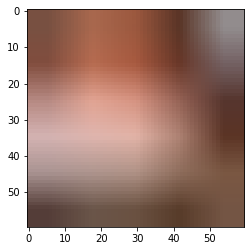

In [280]:
bigger = cv2.resize(image, (60,60))

In [281]:
bigger=bigger/255

In [282]:
bigger=bigger.reshape(1,60,60,3)

In [284]:
pred_val=np.argmax(model.predict(bigger))

1/1 [==============================] - 1s 1s/step


In [285]:
y_pred=[]
for i,j in class_ind.items():
    if pred_val==j:
        y_pred.append(i)

In [287]:
y_pred = model.predict_generator(test_generator)

/var/folders/_r/h6zxn_8952d00xhgshlztwt80000gn/T/ipykernel_55877/3036285124.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator)


In [288]:
y_pred_classes = np.argmax(y_pred, axis = 1)

In [289]:
true_classes = test_generator.classes
class_labels = list(class_ind.keys())

In [291]:
confusion_matrix(true_classes, y_pred_classes)

array([[  0,  27,   4],
       [ 12, 648, 148],
       [  1, 143,  35]])

In [292]:
print(cm)

[[  0  21  10]
 [ 12 654 142]
 [  4 139  36]]


In [294]:
cmm = np.zeros((3, 3))
# Rearrange the Confusion Matrix
cmm[0, 0] = cm[1, 1]
cmm[0, 1] = cm[1, 2]
cmm[0, 2] = cm[1, 0]
cmm[1, 0] = cm[2, 1]

In [295]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() /2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

Confusion matrix, without normalization
[[654. 142.  12.]
 [139.   0.   0.]
 [  0.   0.   0.]]


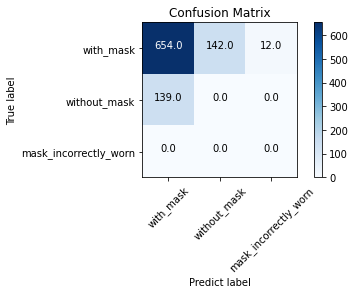

In [299]:
cm_plot_labels = [ 'with_mask', 'without_mask','mask_incorrectly_worn' ]
plot_confusion_matrix(cm=cmm, classes=cm_plot_labels, title='Confusion Matrix')

In [300]:
c_report= classification_report(true_classes, y_pred_classes)

In [301]:
print(c_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.79      0.80      0.80       808
           2       0.19      0.20      0.19       179

    accuracy                           0.67      1018
   macro avg       0.33      0.33      0.33      1018
weighted avg       0.66      0.67      0.67      1018

